Equally Sized Quartile Thresholds: [ 0.  5. 12. 79.]


C:\Users\rosbach\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rosbach\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\rosbach\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rosbach\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2k

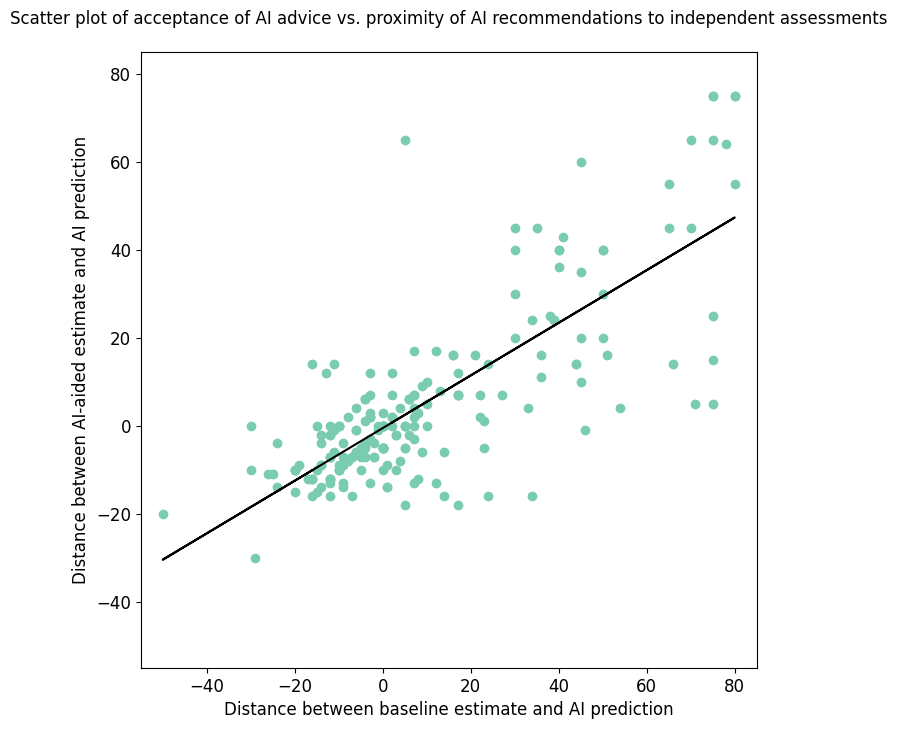

Equally Sized Quartile Thresholds: [ 0.  5. 12. 79.]
15.0


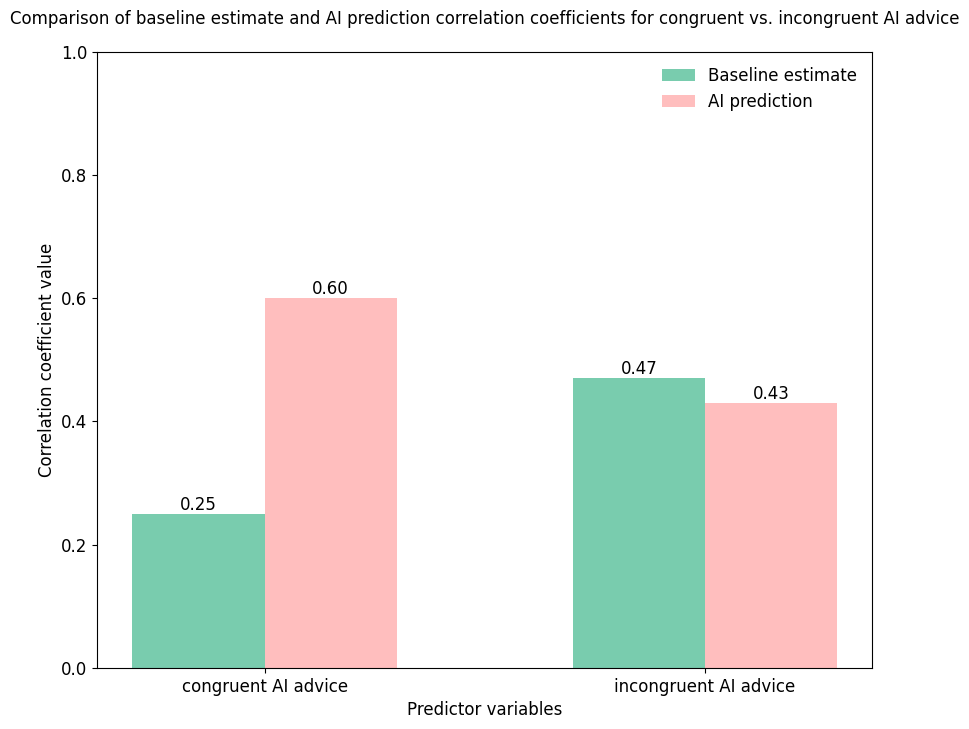

In [3]:
import xlsxwriter
import os
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

def scatterplot ():
    #read data from excel sheet
    df=pd.read_excel('./data.xlsx')
    #filter samples
    df['Equally_Sized_Quartile'], equally_sized_bins = pd.qcut(df['ABS_EstAI2GT'], q=3, labels=["Q1", "Q2", "Q3"], retbins=True)
    print("Equally Sized Quartile Thresholds:", equally_sized_bins)
    #Result: Q1=correct 0-5%, Q2=minor error 6-12%, Q3=severe error 13-79% -> Q2 & Q3 = incorrect
    #distance from AI-assisted estimation to GT has to exceed 5% (incorrect assessment Q2 & Q3) to indicate a notable bias
    df = df[df.EstAI2GT.abs()>5]
    #distances from EstB2GT, PredAI2GT, EstAI2GT all must have the same sign to suggest a consistent tendency for over-/ underestimation between human and machine
    df = df[(df.PredAI2GT * df.EstB2GT)>=0]
    df = df[((df.EstB2GT * df.EstAI2GT)>=0) & ((df.PredAI2GT * df.EstAI2GT)>=0)]
    md=smf.mixedlm("EstAI2PredAI ~ PredAI2EstB", df, groups=df["participant_id"])
    result = md.fit()

    plt.figure(figsize=(10, 8))
    plt.scatter(df['PredAI2EstB'], df['EstAI2PredAI'], color='#79CCAE', alpha=1.0)
    slope, intercept = np.polyfit(df['PredAI2EstB'], df['EstAI2PredAI'], 1)
    plt.plot(df['PredAI2EstB'], slope * df['PredAI2EstB'] + intercept, color='black')
    x_min, x_max = df['PredAI2EstB'].min(), df['PredAI2EstB'].max()
    y_min, y_max = df['EstAI2PredAI'].min(), df['EstAI2PredAI'].max()
    min_limit = min(x_min, y_min)
    max_limit = max(x_max, y_max)
    plt.xlim(min_limit-5, max_limit+5)
    plt.ylim(min_limit-5, max_limit+5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('Distance between baseline estimate and AI prediction', fontsize=12)
    plt.ylabel('Distance between AI-aided estimate and AI prediction', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Scatter plot of acceptance of AI advice vs. proximity of AI recommendations to independent assessments', fontsize=12, pad=20)
    plt.savefig('scatter_plot.pdf', format='pdf')
    plt.show()

def barplot():
    #read data from excel sheet
    df=pd.read_excel('./data.xlsx')

    #filter samples
    df['Equally_Sized_Quartile'], equally_sized_bins = pd.qcut(df['ABS_EstAI2GT'], q=3, labels=["Q1", "Q2", "Q3"], retbins=True)
    print("Equally Sized Quartile Thresholds:", equally_sized_bins)
    #Result: Q1=correct 0-5%, Q2=minor error 6-12%, Q3=severe error 13-79% -> Q2 & Q3 = incorrect
    #distances from the baseline and AI-assisted estimate to the GT exceed 5% (incorrect assessment Q2 & Q3), indicating a notable bias/ error
    df = df[(df.ABS_EstB2GT > 5) & (df.ABS_EstAI2GT > 5)]
    dfi = df
    
    print(np.median(df["ABS_PredAI2EstB"]))
    
    #Model2
    #for the AI prediction to be considered congruent, its distance from the GT also has to exceed 5%
    df = df[df.ABS_PredAI2GT > 5]
    #distances from EstB2GT, PredAI2GT, EstAI2GT all must have the same sign to suggest a consistent tendency for over-/ underestimation between human and machine
    df = df[(df.PredAI2GT * df.EstB2GT)>0]
    df = df[((df.EstB2GT * df.EstAI2GT)>0) & ((df.PredAI2GT * df.EstAI2GT)>0)]
    #for the AI prediction to be considered congruent, it also has to be close to the baseline estimate
    #here the dataset is split based on the median distance from the AI predictions to the baseline estimates
    df = df[df.PredAI2EstB.abs() <= 15]
    
    #Model3 (Comment out Model 2, before commenting this in)
    #for the AI prediction to be considered incongruent, it has to be further away from the baseline estimate
    dfi = dfi[dfi.PredAI2EstB.abs() > 15]
    
    # Model2: mixed linear model with two predictors: EstB and PredAI
    md = smf.mixedlm("EstAI ~ EstB + PredAI", df, groups=df["participant_id"])
    result = md.fit()

    # Model3: mixed linear model with two predictors: EstB and PredAI
    mdi = smf.mixedlm("EstAI ~ EstB + PredAI", dfi, groups=dfi["participant_id"])
    resulti = mdi.fit()

    #get coefficients
    coefficients = result.params[['EstB', 'PredAI']].round(2)
    coefficientsi = resulti.params[['EstB', 'PredAI']].round(2)

    #plot
    labels = ['congruent AI advice', 'incongruent AI advice']
    x = [1, 2]
    baseline = [coefficients.EstB, coefficientsi.EstB]
    ai = [coefficients.PredAI, coefficientsi.PredAI]
    width = 0.3

    plt.figure(figsize=(10, 8))
    bars_baseline = plt.bar(x, baseline, width, label='Baseline estimate', color='#79CCAE')
    bars_ai = plt.bar([p + width for p in x], ai, width, label='AI prediction', color='#FFBEBE')

    for bar in bars_baseline + bars_ai:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

    plt.xticks([p + width/2 for p in x], labels, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 1)
    plt.xlabel('Predictor variables', fontsize=12)
    plt.ylabel('Correlation coefficient value', fontsize=12)
    plt.title('Comparison of baseline estimate and AI prediction correlation coefficients for congruent vs. incongruent AI advice', fontsize=12, pad=20)
    plt.legend(fontsize=12, frameon=False)
    plt.savefig('bar_plot.pdf', format='pdf')
    plt.show()




scatterplot()
barplot()